<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import patsy

sns.set_style('whitegrid')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')
house.shape

(1460, 81)

In [4]:
# A:
house.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [5]:
house.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [6]:
for i in house.columns:
    print i, house[i].dtypes

Id int64
MSSubClass int64
MSZoning object
LotFrontage float64
LotArea int64
Street object
Alley object
LotShape object
LandContour object
Utilities object
LotConfig object
LandSlope object
Neighborhood object
Condition1 object
Condition2 object
BldgType object
HouseStyle object
OverallQual int64
OverallCond int64
YearBuilt int64
YearRemodAdd int64
RoofStyle object
RoofMatl object
Exterior1st object
Exterior2nd object
MasVnrType object
MasVnrArea float64
ExterQual object
ExterCond object
Foundation object
BsmtQual object
BsmtCond object
BsmtExposure object
BsmtFinType1 object
BsmtFinSF1 int64
BsmtFinType2 object
BsmtFinSF2 int64
BsmtUnfSF int64
TotalBsmtSF int64
Heating object
HeatingQC object
CentralAir object
Electrical object
1stFlrSF int64
2ndFlrSF int64
LowQualFinSF int64
GrLivArea int64
BsmtFullBath int64
BsmtHalfBath int64
FullBath int64
HalfBath int64
BedroomAbvGr int64
KitchenAbvGr int64
KitchenQual object
TotRmsAbvGrd int64
Functional object
Fireplaces int64
FireplaceQu object

In [7]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

### Drop the ID 

In [8]:
house = house.drop('Id', axis=1)
house.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


### Change MSSubclass from codes to the respective categories

In [9]:
swap = {20:'1Floor1946New', 30:'1Floor1945Old', 40:'1Floor', 45:'1.5FloorUF',
         50:'1.5FloorF', 60:'2Floor1946New', 70:'2Floor1945Old', 75:'2.5Floor',
         80:'Split/MultiLevel', 85:'SplitFoyer', 90:'Duplex', 120:'1FloorPUD1946New',
         150:'1.5FloorPUD', 160:'2FloorPUD1946New', 180:'PUDMultiLevel', 190:'2FamConv'}

In [10]:
house.MSSubClass.replace(swap, inplace=True)
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,2Floor1946New,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,1Floor1946New,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,2Floor1946New,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,2Floor1945Old,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,2Floor1946New,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


##### Rename column names to prevent conflict with patsy

In [11]:
house = house.rename(columns={'1stFlrSF': 'FirstFlrSF', '2ndFlrSF': 'SecondFlrSF', '3SsnPorch': 'ThreePorch'})

In [12]:
for i in house.columns:
    if house[i].isnull().sum() !=0:
        print i, house[i].isnull().sum()

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


### Understand the meaning of the null values . Some of the null values actually indicate the absence of a specific feature

37 houses have no basement.

1365 houses have no alley access.

690 houses have no fireplace.

79 houses have no garage.

1451 houses have no pool.

1176 houses have no fence.

1402 houses have no miscellaneous features.

### Actual missing data is the following 

LotFrontage has 259 missing values.

MasVnrType + MasVnrArea have 8 missing values.

Electrical has 1 missing value.

Bsmtexposure and Bsmntfin have 1 missing value.

### Swap all the null values in feature to None for better understanding 

In [13]:
# Resolve the 1 missing value in the electrical feature Since it's a single value . 

house['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [14]:
# Since 1334 values belong to Sbrkr we can impute the null value with Sbrkr

In [15]:
house.loc[house['Electrical'].isnull(),'Electrical'] = 'SBrkr'

In [16]:
house['Electrical'].value_counts()

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [17]:
for c in house.columns[house.isnull().sum() > 0]:
    if house[c].dtype == object:
        print c,house[c].value_counts()
        house[c] = house[c].fillna("None")
        print c,house[c].value_counts()

Alley Grvl    50
Pave    41
Name: Alley, dtype: int64
Alley None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
MasVnrType None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
MasVnrType None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
BsmtQual TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
BsmtQual TA      649
Gd      618
Ex      121
None     37
Fa       35
Name: BsmtQual, dtype: int64
BsmtCond TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
BsmtCond TA      1311
Gd        65
Fa        45
None      37
Po         2
Name: BsmtCond, dtype: int64
BsmtExposure No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
BsmtExposure No      953
Av      221
Gd      134
Mn      114
None     38
Name: BsmtExposure, dtype: int64
BsmtFinType1 Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64
BsmtFi

In [18]:
for i in house.columns:
    if house[i].isnull().sum() !=0:
        print i, house[i].isnull().sum()

LotFrontage 259
MasVnrArea 8
GarageYrBlt 81


In [19]:
house['GarageYrBlt'].unique()

array([ 2003.,  1976.,  2001.,  1998.,  2000.,  1993.,  2004.,  1973.,
        1931.,  1939.,  1965.,  2005.,  1962.,  2006.,  1960.,  1991.,
        1970.,  1967.,  1958.,  1930.,  2002.,  1968.,  2007.,  2008.,
        1957.,  1920.,  1966.,  1959.,  1995.,  1954.,  1953.,    nan,
        1983.,  1977.,  1997.,  1985.,  1963.,  1981.,  1964.,  1999.,
        1935.,  1990.,  1945.,  1987.,  1989.,  1915.,  1956.,  1948.,
        1974.,  2009.,  1950.,  1961.,  1921.,  1900.,  1979.,  1951.,
        1969.,  1936.,  1975.,  1971.,  1923.,  1984.,  1926.,  1955.,
        1986.,  1988.,  1916.,  1932.,  1972.,  1918.,  1980.,  1924.,
        1996.,  1940.,  1949.,  1994.,  1910.,  1978.,  1982.,  1992.,
        1925.,  1941.,  2010.,  1927.,  1947.,  1937.,  1942.,  1938.,
        1952.,  1928.,  1922.,  1934.,  1906.,  1914.,  1946.,  1908.,
        1929.,  1933.])

##### For the 81 values missing in GarageyrBlt we can check if they can be  substituted with the value from YearBuilt. First lets check if the other values are similar to eachother

In [20]:
v = 0
for x in house[house.GarageYrBlt.notnull()][['GarageYrBlt','YearBuilt']].values:
    if x[0] == x[1]:
        v += 1
print str(v) + ' Similar values'

1089 Similar values


##### So based on this we could be safe to impute the values from YearBuilt into GarageYrBlt

In [21]:
house.loc[house['GarageYrBlt'].isnull(), 'GarageYrBlt'] = house[house['GarageYrBlt'].isnull()]['YearBuilt']

In [22]:
for i in house.columns:
    if house[i].isnull().sum() !=0:
        print i, house[i].isnull().sum()

LotFrontage 259
MasVnrArea 8


#### For MasVnrArea we can replace it with 0 as per description provided 

In [23]:
house.loc[house['MasVnrArea'].isnull(), 'MasVnrArea'] = 0

In [24]:
for i in house.columns:
    if house[i].isnull().sum() !=0:
        print i, house[i].isnull().sum()

LotFrontage 259


#### For LotFrontage we can impute the mean value of the the existing values in the column. 

In [25]:
house.LotFrontage = house.LotFrontage.fillna(np.mean(house.LotFrontage))

In [26]:
for i in house.columns:
    if house[i].isnull().sum() !=0:
        print i, house[i].isnull().sum()

#### All null values have been resolved so we can proceed with analysing the data

##### Drop all the values for commercial properties 

In [27]:
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [28]:
house = house[house.MSZoning != 'C (all)']

##### Lets look at the obvious connection between Saleprice (Target) & Area

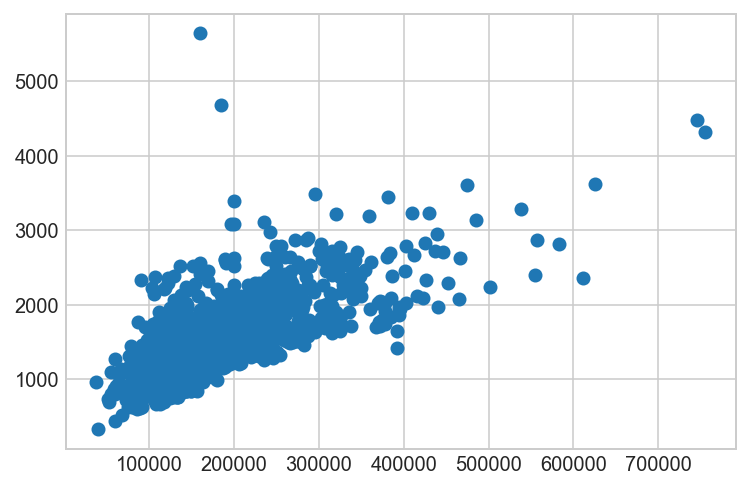

In [29]:
plt.scatter(house.SalePrice, house.GrLivArea)

In [30]:
# Remove outliers where GrLivArea > 4000
house = house[house.GrLivArea < 4000]

In [31]:
house = house.sort_values('YrSold')

In [32]:
house = house.reset_index(drop = True)

##### Set the target 

In [33]:
y_train = house[house['YrSold']<2010]['SalePrice']

In [34]:
y_test = house[house['YrSold']>=2010]['SalePrice']

##### Create a List of Fixed characteristics  

In [35]:
fxd = ['SaleCondition', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 
'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual', 'BsmtExposure',
'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea', 'BsmtFullBath',
'BsmtHalfBath', 'FullBath', 'HalfBath', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars',
'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreePorch', 'ScreenPorch', 'PoolArea',
'MoSold',  'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','YrSold']

In [36]:
fxdcat = []
fxdcon = []

In [37]:
fxdcat = house[fxd].select_dtypes(include = [object]).columns

In [38]:
print fxdcat

Index([u'SaleCondition', u'MSSubClass', u'MSZoning', u'Street', u'Alley',
       u'LotShape', u'LandContour', u'LotConfig', u'LandSlope',
       u'Neighborhood', u'Condition1', u'Condition2', u'BldgType',
       u'HouseStyle', u'Foundation', u'BsmtQual', u'BsmtExposure',
       u'GarageType'],
      dtype='object')


In [39]:
fxdcon = house[fxd].select_dtypes(exclude = [object]).columns

In [40]:
print fxdcon

Index([u'LotFrontage', u'LotArea', u'YearBuilt', u'YearRemodAdd',
       u'BsmtFinSF1', u'BsmtFinSF2', u'TotalBsmtSF', u'FirstFlrSF',
       u'SecondFlrSF', u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath',
       u'FullBath', u'HalfBath', u'Fireplaces', u'GarageYrBlt', u'GarageCars',
       u'GarageArea', u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch',
       u'ThreePorch', u'ScreenPorch', u'PoolArea', u'MoSold', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'YrSold'],
      dtype='object')


In [41]:
corrfxd = " ~ " + " + ".join(fxd) + " + " + "SalePrice" + "-1"

In [42]:
print corrfxd

 ~ SaleCondition + MSSubClass + MSZoning + LotFrontage + LotArea + Street + Alley + LotShape + LandContour + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + YearBuilt + YearRemodAdd + Foundation + BsmtQual + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + TotalBsmtSF + FirstFlrSF + SecondFlrSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + Fireplaces + GarageType + GarageYrBlt + GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreePorch + ScreenPorch + PoolArea + MoSold + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + YrSold + SalePrice-1


In [43]:
X_correlate = patsy.dmatrix(corrfxd, data=house, return_type='dataframe')

In [44]:
corrmat = X_correlate.corr()

In [45]:
corrmat.sort_values('SalePrice', ascending=False)[0:25]['SalePrice']

SalePrice                      1.000000
GrLivArea                      0.720743
GarageCars                     0.651195
TotalBsmtSF                    0.645274
GarageArea                     0.643874
FirstFlrSF                     0.622735
FullBath                       0.554926
TotRmsAbvGrd                   0.537203
YearBuilt                      0.530009
GarageYrBlt                    0.519068
YearRemodAdd                   0.515539
Foundation[T.PConc]            0.502367
Fireplaces                     0.463039
Neighborhood[T.NridgHt]        0.420375
BsmtFinSF1                     0.393968
MSSubClass[T.2Floor1946New]    0.371612
SaleCondition[Partial]         0.371388
OpenPorchSF                    0.345063
LotFrontage                    0.341382
GarageType[T.Attchd]           0.333203
WoodDeckSF                     0.318834
BsmtExposure[T.Gd]             0.307083
SecondFlrSF                    0.297647
Neighborhood[T.NoRidge]        0.290219
HalfBath                       0.279647


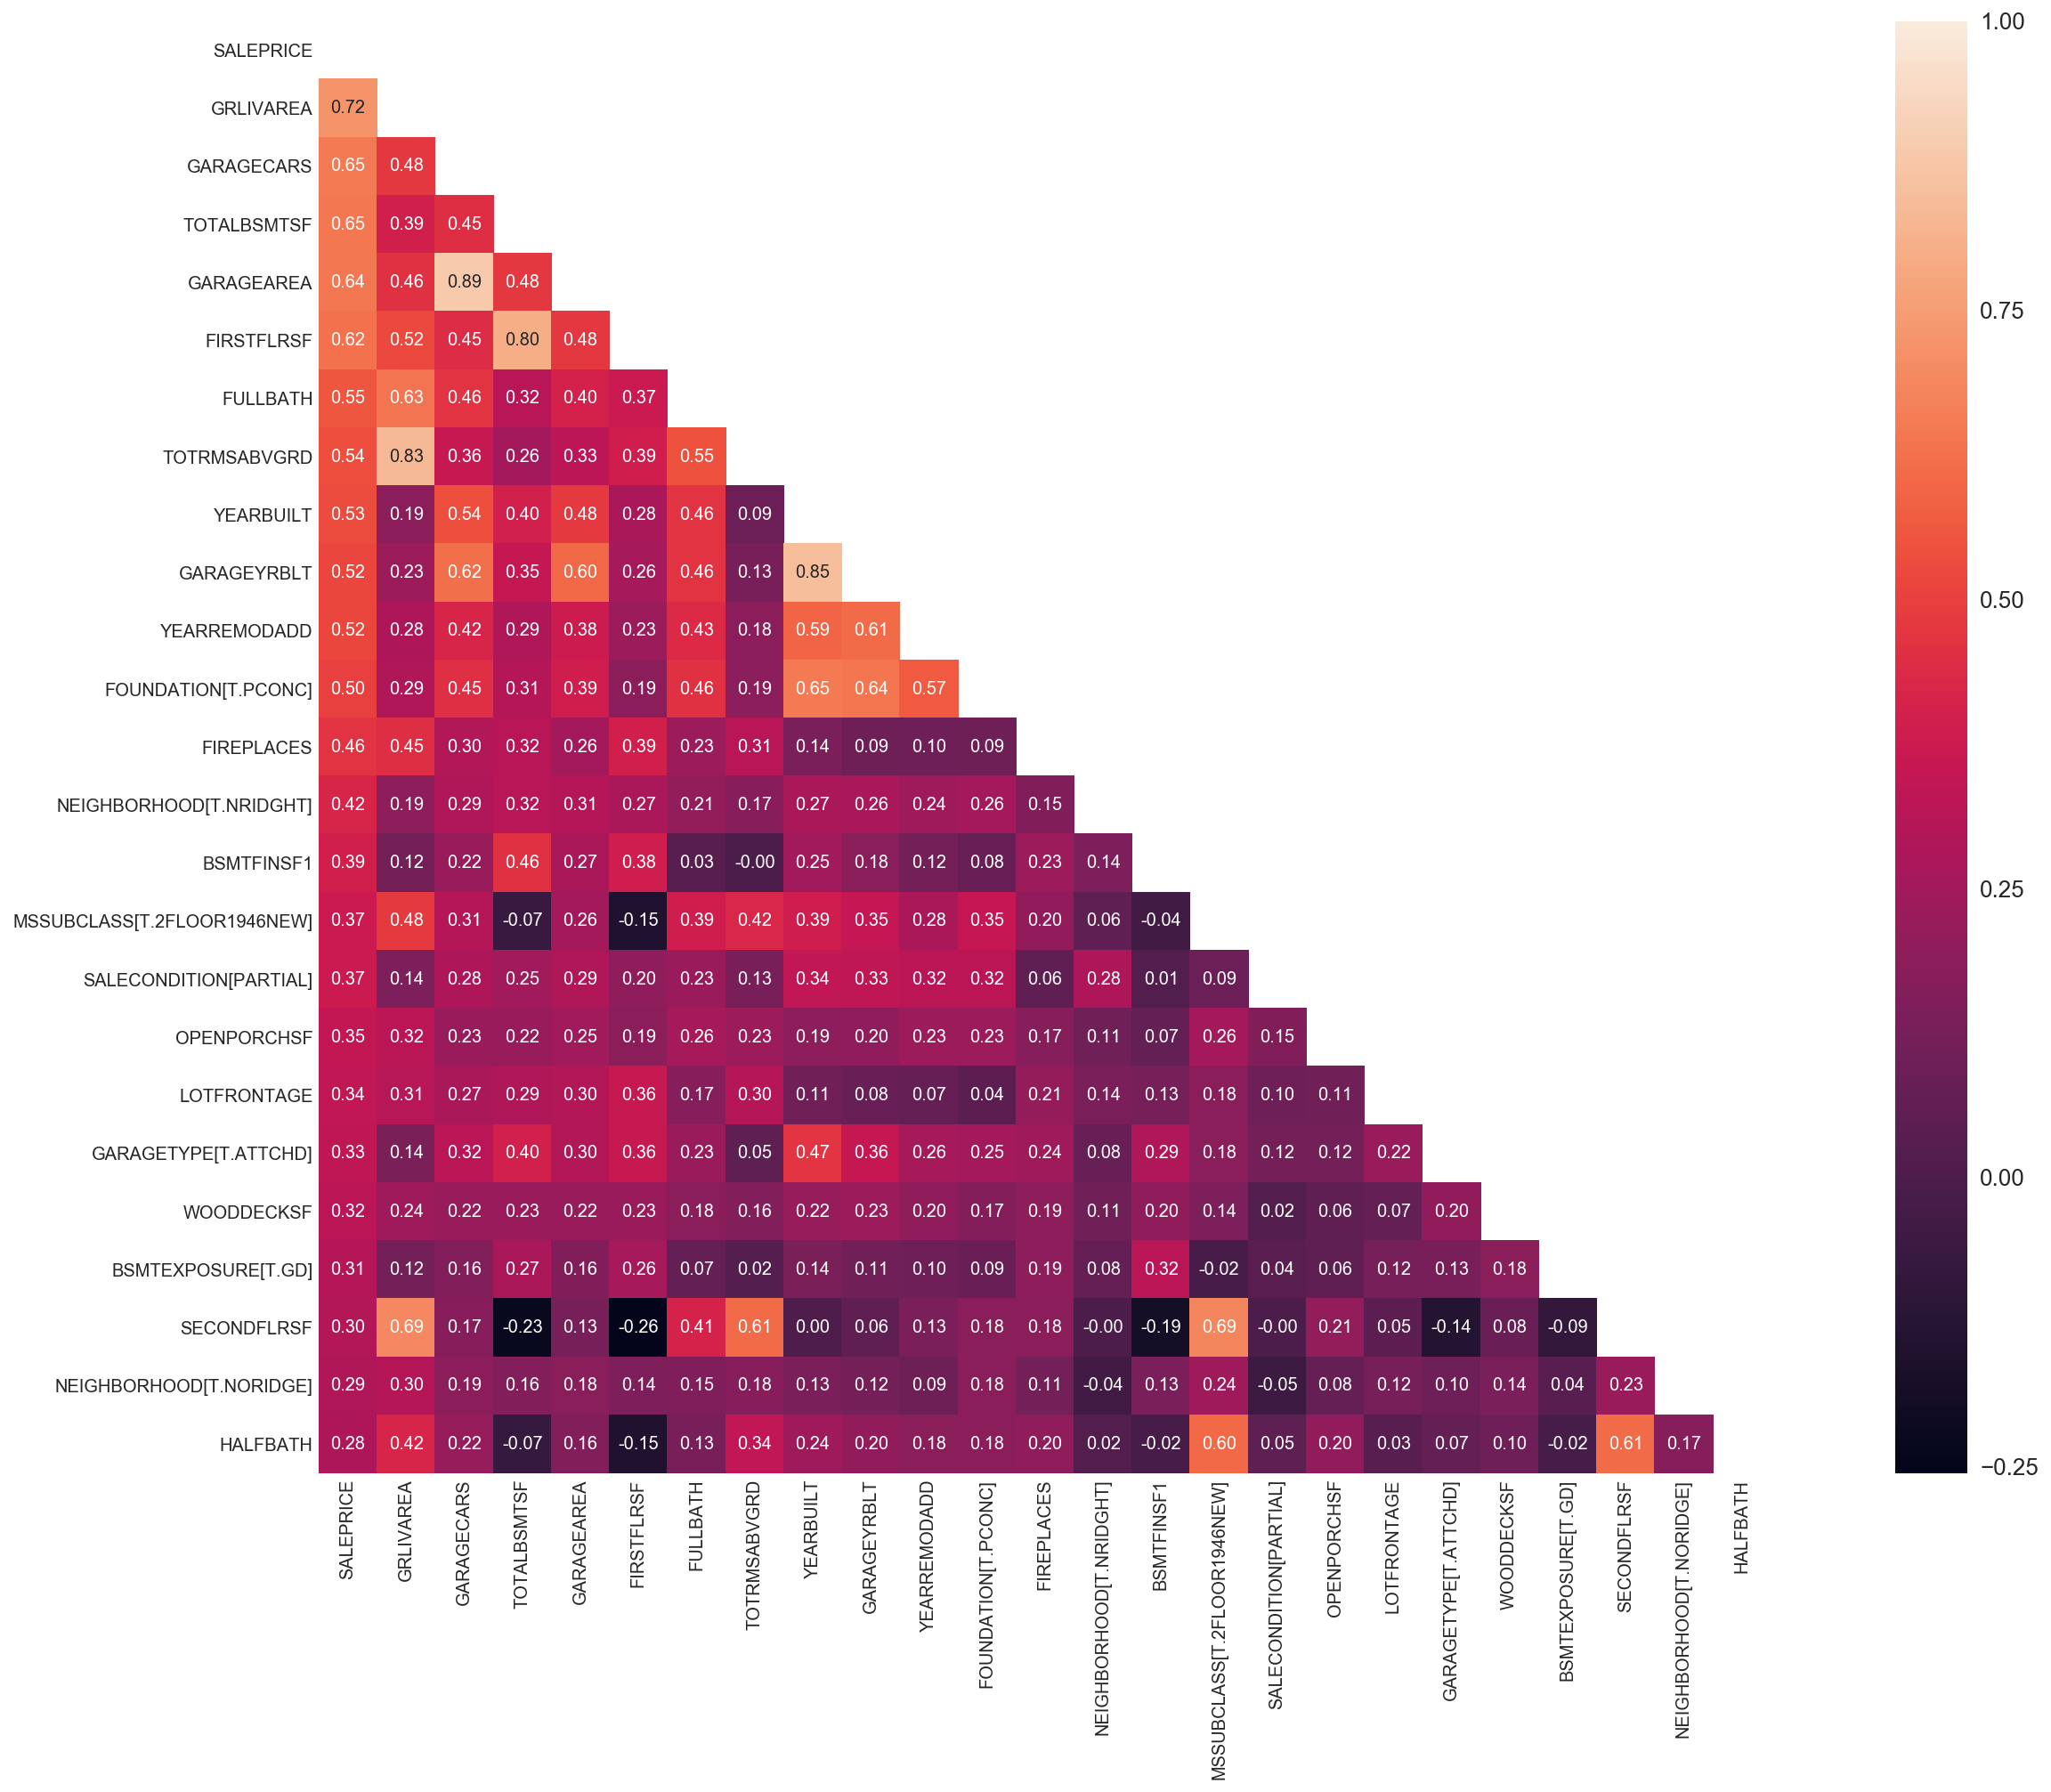

In [46]:
fig, ax = plt.subplots(figsize=(25,15))
cols = corrmat.nlargest(25, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(X_correlate[cols].values.T)
sns.set(font_scale=1.3)
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(cm, cbar=True, annot=True,mask=mask, square=True, annot_kws={'size': 10}, fmt='.2f', yticklabels=map(lambda x: x.upper(), cols.values), xticklabels=map(lambda x: x.upper(), cols.values))
plt.show()

##### Regression with all the fixed features

In [47]:
x_fixed = " ~ "+"+".join(fxdcon)+"+".join(["C("+x+")" for x in fxdcat])

In [48]:
x_fixed

' ~ LotFrontage+LotArea+YearBuilt+YearRemodAdd+BsmtFinSF1+BsmtFinSF2+TotalBsmtSF+FirstFlrSF+SecondFlrSF+GrLivArea+BsmtFullBath+BsmtHalfBath+FullBath+HalfBath+Fireplaces+GarageYrBlt+GarageCars+GarageArea+WoodDeckSF+OpenPorchSF+EnclosedPorch+ThreePorch+ScreenPorch+PoolArea+MoSold+BedroomAbvGr+KitchenAbvGr+TotRmsAbvGrd+YrSoldC(SaleCondition)+C(MSSubClass)+C(MSZoning)+C(Street)+C(Alley)+C(LotShape)+C(LandContour)+C(LotConfig)+C(LandSlope)+C(Neighborhood)+C(Condition1)+C(Condition2)+C(BldgType)+C(HouseStyle)+C(Foundation)+C(BsmtQual)+C(BsmtExposure)+C(GarageType)'

In [132]:
x_fix = ' ~ LotFrontage+LotArea+YearBuilt+YearRemodAdd+BsmtFinSF1+BsmtFinSF2+TotalBsmtSF+FirstFlrSF+SecondFlrSF+GrLivArea+BsmtFullBath+BsmtHalfBath+FullBath+HalfBath+Fireplaces+GarageYrBlt+GarageCars+GarageArea+WoodDeckSF+OpenPorchSF+EnclosedPorch+ThreePorch+ScreenPorch+PoolArea+MoSold+BedroomAbvGr+KitchenAbvGr+TotRmsAbvGrd+YrSold+C(SaleCondition)+C(MSSubClass)+C(MSZoning)+C(Street)+C(Alley)+C(LotShape)+C(LandContour)+C(LotConfig)+C(LandSlope)+C(Neighborhood)+C(Condition1)+C(Condition2)+C(BldgType)+C(HouseStyle)+C(Foundation)+C(BsmtQual)+C(BsmtExposure)+C(GarageType)-1'



In [133]:
X = patsy.dmatrix(x_fix, data=house, return_type='dataframe')

In [134]:
X_train = X[X['YrSold']< 2010]
X_test = X[X['YrSold']>= 2010]

In [135]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [136]:
nscols = [co for co in X_train.columns if co.startswith('C')]

In [137]:
scols = [c for c in X_train.columns if c in fxdcon]

In [138]:
 len(X_train.columns) == len(nscols) + len(scols)

True

In [139]:
standard = StandardScaler()
standard.fit(X_train[scols])
X_std = pd.DataFrame(standard.transform(X_train[scols]),columns=scols)
X_nonstd = X_train[nscols]

In [140]:
Xfix_train = X_std.combine_first(X_nonstd)

In [141]:
Xfix_train.head(4)

,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,C(Alley)[T.None],C(Alley)[T.Pave],C(BldgType)[T.2fmCon],C(BldgType)[T.Duplex],C(BldgType)[T.TwnhsE],...,PoolArea,ScreenPorch,SecondFlrSF,ThreePorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,0.164513,-0.112997,-0.285582,-0.801908,-0.250446,1.0,0.0,0.0,0.0,0.0,...,-0.062143,-0.270429,1.030988,-0.118686,0.304867,-0.705669,-0.753853,0.678250,0.343540,-1.349392
1,0.164513,1.210050,-0.285582,1.136670,-0.250446,1.0,0.0,0.0,0.0,0.0,...,-0.062143,6.328288,1.135160,-0.118686,0.304867,0.082426,0.930819,0.876474,0.634931,-1.349392
2,0.164513,-0.315291,1.600020,-0.801908,3.788386,1.0,0.0,0.0,0.0,0.0,...,-0.062143,-0.270429,-0.804750,-0.118686,-0.317569,0.024228,0.606844,-0.445018,-1.307678,-1.349392
3,-1.061159,-0.110672,-0.285582,-0.801908,-0.250446,1.0,0.0,0.0,0.0,0.0,...,-0.062143,-0.270429,0.128166,-0.118686,-0.317569,-0.271611,-0.753853,-1.039690,0.732062,-1.349392


In [142]:
Xfix_train.shape

(1274, 136)

In [143]:
standard.fit(X_test[scols])
X_std_test = pd.DataFrame(standard.transform(X_test[scols]),columns=scols)
X_nonstd_test = X_test[nscols]

In [145]:
Xfix_test = X_std_test.combine_first(X_nonstd_test)

In [147]:
Xfix_test.head()

,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,C(Alley)[T.None],C(Alley)[T.Pave],C(BldgType)[T.2fmCon],C(BldgType)[T.Duplex],C(BldgType)[T.TwnhsE],...,PoolArea,ScreenPorch,SecondFlrSF,ThreePorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,0.137569,0.170007,-0.326069,0.923649,-0.133235,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.273834,1.262869,-0.105288,0.297029,-0.589117,-0.754544,1.005593,0.712169,0.0
1,0.137569,-1.067434,-0.326069,-0.990418,-0.133235,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.273834,-0.734816,-0.105288,-0.311174,0.409906,-0.754544,1.326686,1.156521,0.0
2,0.137569,-0.208422,4.526478,0.923649,-0.133235,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.273834,-0.734816,-0.105288,0.905232,1.455001,-0.754544,1.112624,0.860287,0.0
3,0.137569,-1.067434,-0.326069,-0.990418,-0.133235,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.273834,1.042194,-0.105288,0.905232,-0.526072,-0.754544,-2.026951,-1.756454,0.0
4,1.382933,-1.067434,-0.326069,-0.990418,-0.133235,1.0,0.0,1.0,0.0,0.0,...,0.0,-0.273834,1.077037,-0.105288,0.905232,-1.689982,1.733190,-2.562106,0.514679,0.0


In [148]:
lr = linear_model.LinearRegression()

In [152]:
model = lr.fit(Xfix_train, y_train)
pred_train = model.predict(Xfix_train)
pred_test = model.predict(Xfix_test)


In [153]:
def errorind(model,xtr,ytr,xte,yte):
    pred_tr = model.predict(xtr)
    pred_te = model.predict(xte)
    print 'Training Set'
    print 'R Square :',model.score(xtr, ytr)
    print 'RMSE :',mean_squared_error(ytr, pred_tr)
    print 'MAE :',mean_absolute_error(ytr, pred_tr)
    print 'Test Set'
    print 'R Square :',model.score(xte, yte)
    print 'RMSE :',mean_squared_error(yte, pred_te)
    print 'MAE :',mean_absolute_error(yte, pred_te)

In [154]:
errorind(model,Xfix_train,y_train,Xfix_test,y_test)

Training Set
R Square : 0.908228403511
RMSE : 528888719.433
MAE : 16150.4050235
Test Set
R Square : 0.895413121076
RMSE : 664900530.174
MAE : 17496.8372093


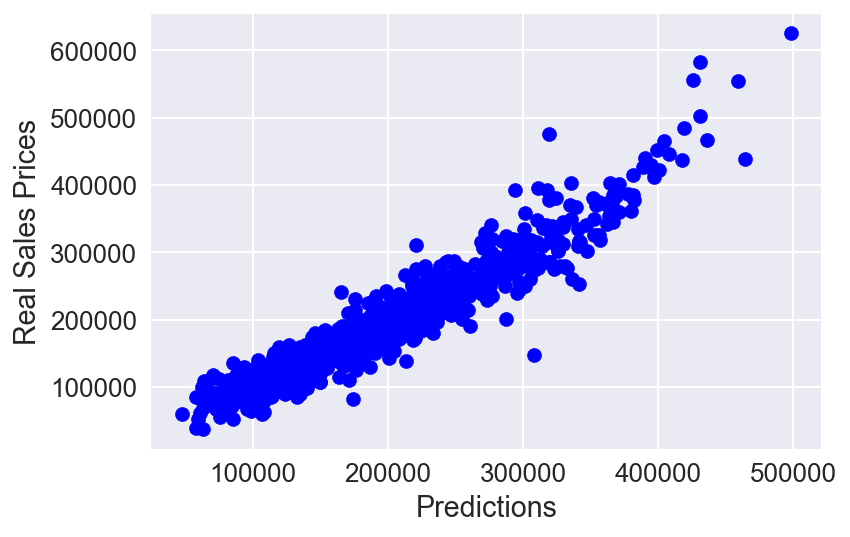

In [160]:
plt.scatter(pred_train, y_train, c='b')
plt.xlabel("Predictions")
plt.ylabel("Real Sales Prices")
plt.show()

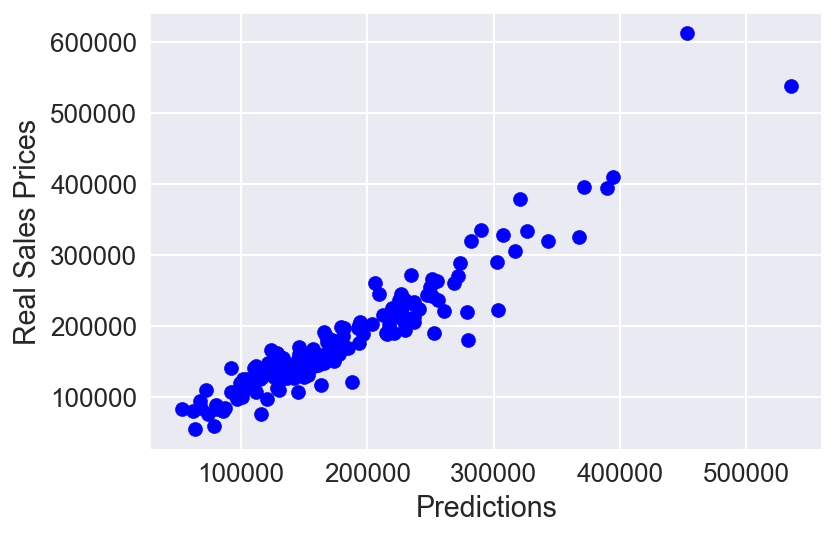

In [161]:
plt.scatter(pred_test, y_test, c='b')
plt.xlabel("Predictions")
plt.ylabel("Real Sales Prices")
plt.show()

In [162]:
model.coef_

array([ -5.97139552e+03,   7.40561427e+03,   7.89111014e+01,
         1.02766650e+03,  -4.58077674e+02,   1.21790598e+02,
        -9.87781200e+02,  -1.54677196e+04,   5.89621162e+17,
        -2.78800000e+03,  -4.25600000e+03,   1.80920000e+04,
        -2.27600000e+03,  -6.60900000e+03,  -1.62246250e+04,
        -2.39985000e+04,  -3.15660000e+04,   9.66600000e+03,
        -2.55920000e+04,  -3.40800000e+03,   4.89000000e+03,
         8.92000000e+03,   4.87000000e+03,  -2.29240000e+04,
        -2.60825000e+03,   2.82650000e+03,  -2.25250000e+02,
        -3.62200000e+03,  -5.58400000e+03,   8.08900000e+04,
        -1.12247891e+04,  -5.45690000e+04,  -1.43295000e+04,
        -3.79700000e+03,  -2.79200000e+03,   1.00000000e+03,
        -4.76900000e+03,   4.29500000e+03,  -2.59590000e+04,
         2.12377500e+04,   2.05920000e+04,   2.85480000e+04,
         3.44000000e+02,   2.54960000e+04,   2.93000000e+04,
         6.12800000e+03,   1.20800000e+03,  -4.13600000e+03,
        -1.48080000e+04,

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: